# Automate the HuBMAP data formatting pipeline.
- These scripts will loop through the directory containing all of the HuBMAP single-cell studies (63 in total).
- The only input will be the path to this directory and the metadata directory
- The output will be a set of CSVs for each study containing data ready to be imported into Neo4j (these CSVs will need to be concatenated to the rest of the UMLS CSVs in the aggregate-files notebook.)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', 500)

import os
import numpy as np
from collections import Counter
import collections

import json
import anndata
from scipy.io import mmread
import gzip
from scipy import sparse
import matplotlib.pyplot as plt
#from matplotlib_venn import venn2, venn3
import urllib
import time
#import vpolo
#from vpolo.alevin import parser
#import zarr
from umls_utils import get_paths, CUIbase64

In [23]:
!jupyter nbconvert --to script --no-prompt hubmap_automated_workflow.ipynb
!sed -i '' '/.head(/d' hubmap_automated_workflow.py
!sed -i '' '/^#/d' hubmap_automated_workflow.py
!sed -i '' '/get_ipython()/d' hubmap_automated_workflow.py

[NbConvertApp] Converting notebook hubmap_automated_workflow.ipynb to script
[NbConvertApp] Writing 51195 bytes to hubmap_automated_workflow.py


In [68]:
#data_dir = '/mnt/isilon/taylor_lab/CFDE/HuBMAP/10x_data_download/globus_files/hubmap_dec2021/'  

#helper_data_dir = '/home/stearb/R03_HUBMAP/use_config/HELPER_FILES/'
# scp -r /Users/stearb/Desktop/R03_local/data/use_config/HELPER_FILES/ stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/use_config/

#umls_dir = '/home/stearb/R03_HUBMAP/UMLS_FILES/FREEZE/'
#scp -r /Users/stearb/Desktop/hubmap-kg/FREEZE/ stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/use_config/UMLS_FILES/

#output_dir = '/home/stearb/R03_HUBMAP/use_config/OUTPUT_FILES/'

#!jupyter nbconvert --to script --no-prompt hubmap_automated_workflow.ipynb

# upload this script: 
# scp /Users/stearb/Dropbox/CHOP/R03/code/HubMAP_ingestion/hubmap_automated_workflow.py stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/code/
# upload umls_utils script: scp /Users/stearb/Dropbox/CHOP/R03/code/HubMAP_ingestion/umls_utils.py stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/code/
# upload config.ini scp /Users/stearb/Dropbox/CHOP/R03/code/HubMAP_ingestion/config.ini stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/code/


# scp stearb@franklin.research.chop.edu:/home/stearb/R03_HUBMAP/code/study_statistics.csv /Users/stearb/Dropbox/CHOP/R03/code/HubMAP_ingestion/

# scp -r stearb@franklin.research.chop.edu:/mnt/isilon/taylor_lab/CFDE/HuBMAP/HuBMAP_CSVs/HUBMAPsc/* /Users/stearb/Desktop/R03_local/data/use_config/OUTPUT_FILES/HUBMAPsc/

In [2]:
#!/bin/bash
# echo 'starting hubmap workflow...';
# python3 /home/stearb/R03_HUBMAP/code/hubmap_automated_workflow.py;
# exit;

SyntaxError: invalid syntax (<ipython-input-2-2e825cd62e79>, line 2)

In [ ]:
# How to run script on cluster from local terminal
# ssh stearb@franklin.research.chop.edu 'bash -s' < hubmap_bash.sh
# scp -r stearb@franklin.research.chop.edu:/mnt/isilon/taylor_lab/CFDE/HuBMAP/HuBMAP_CSVs/ /Users/stearb/Desktop/R03_local/data/use_config/OUTPUT_FILES/HUBMAP/
    

In [24]:
data_dir

'/Users/stearb/Desktop/R03_local/data/use_config/R03_DATA/'

In [2]:
ON_HPC_CLUSTER = False

# Get paths from config file
if ON_HPC_CLUSTER: config_path = '/home/stearb/R03_HUBMAP/code/'
else:config_path = '/Users/stearb/Dropbox/CHOP/R03/code/neo4j_build_CFDIKG/build_scripts/'

data_dir,helper_data_dir,output_dir,LOCAL_CPU,umls_dir,umls_out_dir = get_paths(config_path)

if not os.path.isdir(output_dir+'HUBMAPsc') and not ON_HPC_CLUSTER:
    os.mkdir(output_dir+'HUBMAPsc')
    print('Creating HuBMAPsc directory...')

In [3]:

study_ids = ['046251c94ea0e79ee935dd3de57e093c',  '3f678ab5cd7ed086ec0d2d4468fc5094',  '81a9fa68b2b4ea3e5f7cb17554149473', 'be103f95cc6c1a3e48f099d1bd149a49',
'04968c1fe0149ee367b0e53af55763e4',  '42ab155ddff1d33fe1c505c067828614',  '846e56ed969922f1cb7a81619b175620',  'c019a1cd35aab4d2b4a6ff221e92aaab',
'0576b972e074074b4c51a61c3d17a6e3',  '434fbc55d458dc4e06da9ba4961f3840',  '853ab5348f619043ab2f997ac8ae14f0',  'c05a38c5210b870281b5aea01e290339',
'0d1eb3d774a694b79e844987f771b183',  '4b16c24a3997ea8754921b0f1d60bc4d',  '8e2806ca447695e674889dba28506d38',  'd48b7990d638dbede870ae9c1976e475',
'1197c73d127193dd493ff542890a3d3d',  '53fe8a84564b313d4e8ee90f337129dc',  '91822c7d75c54ce838bcd4d77f076b25',  'd9780d3f4eb9edfe275abaa32ff8633b',
'14946a8eb12f2d787302f818b72fdc4e',  '59249f23ecdcc975c90de9a1956a5285',  '91cfb45f5d398e950ed65786c87f4372',  'e375a44f5cf5457c8f9b1132574c2436',
'1ca63edfa35971f475c91d92f4a70cb0',  '5d111a1db2f18d507d23e79b993e1e4a',  '92248f72d47b916a2027085ec1b8e996',  'e65175561b4b17da5352e3837aa0e497',
'277152f17b5a2f308820ab4d85c5a426',  '68159e4bd6a2cea1cd66e8f3050cfcb7',  '9a36e5319429ec6aca5a8a9fef401929',  'e8d642084fc5ec8b5d348ebab96a4b22',
'29a538c3ddb396dee26188ae1151da46',  '6cd63d0ee2c67c3be41e4be1522d9c07',  '9aed52d22e30b893045fd1f79b3663fb',  'ed630484e46ea49b319c0e1f92140059',
'2ab4c834a887341b8746a3e42143d786',  '7017034c816444f6acb469834e53344f',  '9fe24e50c8b8b77d86900ee4beecef69',  'eec6f3356dc3078c957baaa740849fcc',
'319aafd9420a0c1c6f175d6a2ef060a9',  '71477f504b0069828a368009fa3ab1ad',  'aaedb5272190e61bf557d3b0a1bc591f',  'f2647d9533956fdb12da6b1fc6254441',
'35a639b983ff85728bdb3cbe0eac360a', '739184f7ec84d93a35360cde81cc026c',  'b1f17d04de81b0a8a8e2b894308498d3',  'f412e76986c1012ea9589d545ed8f043',
'35f5b75a7e3d0711f16b0a10219586fb',  '747bd5b3f6fef699bcd6363ff51e59d9',  'b299e98235f157534445f00884ae7c44',  'f71249f6e349fb9a99a3d4f08541cab4',
'391061b538480d6d630bdfec283c0293',  '7646a8a89555a123a56446b66c183d58',  'b340bb5715f967aa74d1b8eaeec0d475',  'f9848244883f6c70972acef16680431a',
'3ac0768d61c6c84f0ec59d766e123e05',  '79f087ae551dd72997f174646bb0d5e0',  'ba3081716f3fa98a1670b0864c5115ff',  'faa1acc13943ee9d365b6cc6a3ea889f',
'3bb5f743b039cb620d7ef234e0876f7a',  '7b99b447ffc977a3f6f890d32c7238b3',  'bdfebbfbbaa33bf1d2a5ae4c31cde1de']

In [4]:
if ON_HPC_CLUSTER:
    HuBMAP_STUDY_DIR = data_dir
else:
    HuBMAP_STUDY_DIR = data_dir+'HUBMAPsc_studies/'

In [5]:
#!ls /Users/stearb/Desktop/R03_local/data/use_config/R03_DATA/HUBMAPsc_studies/

## Load in and define data needed downstream  
- hgnc_master = symbol <-> hgnc code mappings
- UMLS hgnc CUI-Code mappings
- expression bins (we are using the same bins from gtex)
- UMLS BMI bins and CUIs

In [6]:
hgnc_master = pd.read_csv(helper_data_dir+'hgnc_master.txt','\t')

# First, GET CUI - HGNC CODE MAPPINGS STRAIGHT FROM CSVs
UMLS_CUI_CODEs = pd.read_pickle(umls_dir+'CUI-CODEs.pickle')

umls_genes = UMLS_CUI_CODEs[UMLS_CUI_CODEs[':END_ID'].str.startswith('HGNC')].rename(columns={':START_ID':'CUI_hgnc',':END_ID':'hgnc_id'})
umls_genes['hgnc_id'] = [i.split(' ')[1] for i in umls_genes['hgnc_id']]

# These bins are taken directly from the GTEx bins, (GTEx has tpm or Transcripts per Million, 
# but we can use the same bins for the normed gene expression we have for the sc data here.)
tpm_bins = list([0.0000000,7e-4,8e-4,9e-4]) + list(np.linspace(1e-3,9e-3,9)) + \
           list(np.round(np.linspace(1e-2,9e-2,9),2)) + list(np.round(np.linspace(.1,1,10),2)) + \
           list(np.linspace(2,100,99)) + list(np.arange(100,1100,100)[1:]) +  \
            list(np.arange(2000,11000,1000)) + list(np.arange(20000,110000,10000)) + [300000]

# Load BMI CodeIDs and merge with CUIs so we can map HUBMAP donor BMIs to the appropriate BMI CUI (which are bins from SNOMED)
#bmi_codes = pd.read_excel('/Users/stearb/Downloads/Book1.xlsx')
#bmi_codes[(bmi_codes['Code'].str.startswith('SNOMEDCT_US')) &  (bmi_codes['TTY']=='PT')]
#bmi_select = ['SNOMEDCT_US 310252000','SNOMEDCT_US 162864005','SNOMEDCT_US 427090001', 'SNOMEDCT_US 412768003','SNOMEDCT_US 162863004','SNOMEDCT_US 408512008']
#bmi_select_codes = bmi_codes[(bmi_codes['Code'].isin(bmi_select)) & (bmi_codes['TTY']=='PT')]
#bmi_cui_codes = pd.merge(bmi_select_codes,UMLS_CUI_CODEs.rename(columns={':START_ID':'CUI',':END_ID':'Code'}),on='Code',how='left')
bmi_cui_binned = [['C0587773', 'C0424671', 'C1959901', 'C1445936', 'C0424672','C1319441'],
                [[0,16.5],[16.5001,19.9999],[20,24.999],[25,29.999],[30,39.999],[40,75]]]
df_bmi = pd.DataFrame(np.transpose(bmi_cui_binned),columns=['CUI','BMI Bins'])

In [7]:
# Find all tissue/organ codes from metadata json file usually located in rui_location field, although
# tissue/organ data may be in another field as well.

def get_all_organ_CUIs(study_ids):
    organs_and_tissues = list()

    for filename in study_ids:
        request = urllib.request.urlopen(f'https://portal.hubmapconsortium.org/browse/dataset/{filename}.json')
        j = json.load(request)
        x=0
        for i in j['ancestors']:
            if 'rui_location' in i.keys(): x = i['rui_location']  #print(json.dumps(i['rui_location'], indent=2))

        if x==0: 
            print('No organ metadata found in rui_location field: '+filename)
        else:
            organ_metadata = json.loads(x)['ccf_annotations']
            organ_CodeIDs = [i.split('/')[-1] for i in organ_metadata]

            if len(organ_CodeIDs): organs_and_tissues.append(organ_CodeIDs)

    organs_flat = [item for sublist in organs_and_tissues for item in sublist]

    # take just the uberon terms and format to match the umls code ids for merging the uberon cuis in
    organs_flat = [i.replace('_',' ') if i.startswith('UBERON') else i for i in organs_flat]
    # add space in middle of FMA Codes
    organs_flat = [i.upper()[:3]+' '+i[3:] if i.startswith('fma') else i for i in organs_flat] 

    df_organs = pd.DataFrame(organs_flat,columns=['tissue_id']).drop_duplicates().reset_index(drop=True)

    umls_organs = UMLS_CUI_CODEs[UMLS_CUI_CODEs[':END_ID'].str.startswith(('UBERON','NCI ','FMA '))].rename(
                                        columns={':START_ID':'CUI_tissue',':END_ID':'tissue_id'})

    organs_master = pd.merge(df_organs,umls_organs,on='tissue_id',how='left')
    
    return organs_master

In [8]:
def get_metadata(filename):
    request = urllib.request.urlopen(f'https://portal.hubmapconsortium.org/browse/dataset/{filename}.json')
    return json.load(request)

def get_matrix(filename):
    if os.path.exists(study_path+'/expr.h5ad'):
        expr = anndata.read_h5ad(filename=study_path+'/expr.h5ad')
    elif os.path.exists(study_path+'/out.h5ad'):
        expr = anndata.read_h5ad(filename=study_path+'/out.h5ad')
    else:
        print('No file named "expr.h5ad" or "out.h5ad" found.')
    
    # FIX and test spliced_unspliced_sum matrrix ingestion
    #expr.layers['spliced_unspliced_sum'].todense()
    #
    sparse_mat = expr._X
    symbols = expr.var
    sample_barcodes = expr._obs.index.to_frame(name='barcodes').reset_index(drop=True)
    df_exp = pd.DataFrame(sparse_mat.todense())
    df_exp.columns = symbols.index.to_list()
    df_exp.index = [i[0] for i in sample_barcodes.values]
    
    assert len(symbols.index.to_list()) == len(np.unique(symbols.index.to_list())), 'Ensembl genes not unique'
    assert len(df_exp.index.to_list()) == len(np.unique(df_exp.index.to_list())), 'Barcodes not unique'
    
    return df_exp, sample_barcodes


def determine_spatial(filename):
    '''Determine if the HuBMAP study is a spatial study or not'''
    SPATIAL_FLAG = False
    #check spatial data metadata 
    request = urllib.request.urlopen(f'https://portal.hubmapconsortium.org/browse/dataset/{filename}.json')
    j = json.load(request)
    
    for ancestor in j['ancestors']:
        # Find the 'Dataset' json obj
        if ancestor['entity_type'] == 'Dataset': 
            for datatype in ancestor['data_types']:
                # caseless string matching, .casefold() is better,
                #  also leave room to check for other spatial protocols, not just slide-seq
                if datatype.lower()=='Slide-seq'.lower(): SPATIAL_FLAG = True             
    return SPATIAL_FLAG, j

In [9]:
def get_cluster_dict(study_path,df_exp):
    # why do sample_and_clusters and sampleClusterMap not have the same length?
    CLUSTER_FLAG = 1 # report back on whether we found cluster data or not
    cluster_dict = {}
    
    CLUSTER_PATH_1 = '/hubmap_ui/output/secondary_analysis.factors.json'
    CLUSTER_PATH_2 = '/cluster-marker-genes/output/cluster_marker_genes.factors.json'
    
    if os.path.exists(study_path+CLUSTER_PATH_1):
        with open(study_path+CLUSTER_PATH_1, 'r') as f: contents = json.loads(f.read())
            
    elif os.path.exists(study_path+CLUSTER_PATH_2): 
        with open(study_path+CLUSTER_PATH_2, 'r') as f: contents = json.loads(f.read())          
    else:
        print('No cluster data found, using entire matrix as cluster 0.')
        CLUSTER_FLAG = 0
        cluster_dict[0.0] = df_exp # set entire matrix as cluster 0
        unique_clusters = [0] # just the single cluster, so return this
        return cluster_dict, unique_clusters,CLUSTER_FLAG
        
    samples_and_clusters = pd.Series(contents['Leiden Cluster']['cells'])
    samples_and_clusters['clustered_samples'] = samples_and_clusters.index.to_list()
    samples_and_clusters = pd.DataFrame(contents['Leiden Cluster']['cells'].items(),columns=['barcodes','cluster'])
    sampleClusterMap  = pd.merge(sample_barcodes,samples_and_clusters,on='barcodes',how='left')
    unique_clusters = np.sort(sampleClusterMap['cluster'].dropna().unique())
    
    for CLUSTER in unique_clusters:
        # Get samples (barcodes) for each cluster
        cluster_N_samples = sampleClusterMap[sampleClusterMap['cluster'] == CLUSTER]['barcodes'].values
        cluster_N_mask = [i[0] for i in df_exp.index.to_frame().isin(cluster_N_samples).values] 
        df_cluster_N = df_exp[cluster_N_mask]
        cluster_dict[CLUSTER] = df_cluster_N
        assert len(df_cluster_N) == len(cluster_N_samples)
    
    return cluster_dict, unique_clusters, CLUSTER_FLAG

In [10]:
def process_clusters(cluster_dict,unique_clusters):
    # get cluster lengths for normalizing gene sums
    clusters_lensum = 0
    cluster_sample_nums = {}
    for CLUSTER in unique_clusters:
        #print(cluster_dict[CLUSTER].shape)
        clusters_lensum = clusters_lensum + cluster_dict[CLUSTER].shape[0] 
        cluster_sample_nums[CLUSTER] = cluster_dict[CLUSTER].shape[0]
        
    # Sum gene expressions per cluster and drop genes whose sum == 0    
    gene_exp_sum_dict = {}
    for CLUSTER in unique_clusters:
        gene_sums=cluster_dict[CLUSTER].sum()
        gene_sums = gene_sums[gene_sums > 0.00]   
        gene_exp_sum_dict[CLUSTER] = gene_sums 
        
    # How many Nones are there in each cluster?
    for CLUSTER in unique_clusters:
        c = gene_exp_sum_dict[CLUSTER]
        total_len  = len(c)
        nones = [x for x in c.index.tolist() if x is None] 
        assert len(nones) == 0
        
    # Normalize gene expression by # of cells per cluster
    gene_exp_sum_normed = {}
    for CLUSTER in unique_clusters:                   
        gene_exp_sum_normed[CLUSTER] = gene_exp_sum_dict[CLUSTER] / cluster_sample_nums[CLUSTER]
        
    # Add cluster column
    gene_exp_sum_clust = {}
    for CLUSTER in unique_clusters:
        temp = pd.DataFrame(gene_exp_sum_normed[CLUSTER])
        temp['cluster'] = str(CLUSTER)
        gene_exp_sum_clust[CLUSTER]  = temp
        
    for CLUSTER in unique_clusters:
        if CLUSTER == 0:
            all_cluster_df = gene_exp_sum_clust[CLUSTER] # this should be okay if we only have a single cluster.
        else:
            all_cluster_df = all_cluster_df.append(gene_exp_sum_clust[CLUSTER])

    # check all clusters were appended
    length_all_clusters = 0
    for CLUSTER in unique_clusters:
        length_all_clusters = length_all_clusters + len(gene_exp_sum_clust[CLUSTER])
    assert length_all_clusters == len(all_cluster_df)        


    all_cluster_df['ensembl_id'] = all_cluster_df.index.to_list()
    all_cluster_df['unique_hubmap_del'] =  all_cluster_df['cluster'].astype(str) + ' ' + all_cluster_df['ensembl_id']
    all_cluster_df = all_cluster_df.rename(columns={0:'gene expression normed'})
    all_cluster_df['ensembl_match'] = [i.split('.')[0] for i in all_cluster_df['ensembl_id'].values]
    assert all_cluster_df.duplicated().sum() == 0
    
    # Need to add in cluster data here to create hubmap-cluster CUI-CUIs
    all_cluster_df['CODE_cluster'] = [metadata['uuid']+' CLUSTER '+i.split('.')[0] for i in all_cluster_df['cluster'].values]
    all_cluster_df['SAB'] = 'HUBMAPsc CLUSTER'
    all_cluster_df['CodeID_cluster'] = all_cluster_df['SAB'] + ' ' + all_cluster_df['CODE_cluster'] 
    all_cluster_df['CUI_cluster'] = CUIbase64(all_cluster_df['CodeID_cluster'])

    return all_cluster_df

In [11]:
def merge_hgnc_cuis(all_cluster_df,hgnc_master,metadata,umls_genes):
    '''merge in HGNC gene names and their CUIs'''
    ensembl_hgnc_map = hgnc_master[['hgnc_id','ensembl_gene_id']].rename(columns={'ensembl_gene_id':'ensembl_match'})
    df_ens_hgnc = pd.merge(all_cluster_df,ensembl_hgnc_map,on='ensembl_match')
    assert df_ens_hgnc.isna().sum().sum() == 0

    # merge in CUIs
    df = pd.merge(df_ens_hgnc,umls_genes,on='hgnc_id')
    
    # Create HuBMAP CUI,CodeID,CODE,SAB (study_id + cluster_# + CUI_hgnc + hgnc_id), study_id == metadata['uuid'] 
    df['HuBMAP_CODE'] = metadata['uuid'] +' '+'cluster ' + \
                pd.Series([i[0] for i in df['cluster'].astype(str).str.split('.')]) + \
                ' ' +  df['CUI_hgnc'] + ' ' + df['hgnc_id']
    
    df['SAB'] = 'HUBMAPsc'
    df['HuBMAP_CODE_ID'] = df['SAB']+ ' ' + df['HuBMAP_CODE']
    df['CUI_HuBMAP']  = CUIbase64(df['HuBMAP_CODE_ID'])

    return df

In [12]:
def create_hubmap_hgnc_cluster_cui_cuis(df):
    '''create hubmap-hgnc CUI-CUI relationships (and the reverse rels)
       create hubmap-cluster CUI-CUI Relationships (and the reverse rels) '''
    ######### CUI-CUI (HuBMAP -- HGNC)
    HuBMAP_HGNC_CUI_CUI = df[['CUI_HuBMAP','CUI_hgnc']]
    HuBMAP_HGNC_CUI_CUI[':TYPE'] = 'hubmap_study_has_gene_expression'
    HuBMAP_HGNC_CUI_CUI['SAB'] = 'HUBMAPsc__HGNC' 
    # Same thing but reversed
    HuBMAP_HGNC_CUI_CUI_REVERSE = df[['CUI_hgnc','CUI_HuBMAP']]
    HuBMAP_HGNC_CUI_CUI_REVERSE[':TYPE'] =  'gene_expression_of_hubmap_study'
    HuBMAP_HGNC_CUI_CUI_REVERSE['SAB'] = 'HUBMAPsc__HGNC' 
    HuBMAP_HGNC_CUI_2_CUIs = pd.concat([HuBMAP_HGNC_CUI_CUI.rename(columns={'CUI_HuBMAP':':START_ID','CUI_hgnc':':END_ID'}),HuBMAP_HGNC_CUI_CUI_REVERSE.rename(columns={'CUI_hgnc':':START_ID','CUI_HuBMAP':':END_ID'})])

    assert HuBMAP_HGNC_CUI_2_CUIs.shape[1] == 4, 'CUI-CUI incorrect cols'

    ######## CUI-CUI  (HUBMAP--CLUSTER)
    HuBMAP_CLUSTER_CUI_CUI = df[['CUI_HuBMAP','CUI_cluster']].rename(columns={'CUI_HuBMAP':':START_ID','CUI_cluster':':END_ID'})
    HuBMAP_CLUSTER_CUI_CUI[':TYPE'] = 'hubmap_node_belongs_to_cluster'
    HuBMAP_CLUSTER_CUI_CUI['SAB'] = 'HUBMAPsc__CLUSTER' 
    # Same thing but reversed
    HuBMAP_CLUSTER_CUI_CUI_REVERSE = df[['CUI_cluster','CUI_HuBMAP']].rename(columns={'CUI_HuBMAP':':END_ID','CUI_cluster':':START_ID'})
    HuBMAP_CLUSTER_CUI_CUI_REVERSE[':TYPE'] =  'cluster_has_hubmap_node'
    HuBMAP_CLUSTER_CUI_CUI_REVERSE['SAB'] = 'HUBMAPsc__CLUSTER' 
    HuBMAP_CLUSTER_CUI_2_CUIs = pd.concat([HuBMAP_CLUSTER_CUI_CUI,HuBMAP_CLUSTER_CUI_CUI_REVERSE])

    assert len(HuBMAP_CLUSTER_CUI_2_CUIs) == len(HuBMAP_HGNC_CUI_2_CUIs)
    assert HuBMAP_CLUSTER_CUI_2_CUIs.shape[1] == 4, 'HUBMAP-CLUSTER CUI-CUI incorrect cols'
    assert HuBMAP_HGNC_CUI_2_CUIs.shape[1] == 4, 'HUBMAP-HGNC CUI-CUI incorrect cols'

    return HuBMAP_HGNC_CUI_2_CUIs,HuBMAP_CLUSTER_CUI_2_CUIs

In [13]:
# Need to manually add CUIs to organ/tissue codes w/ no matching CUIs !!!!

# there are multiple tissues mapped to one study, should we just map hgnc rel's to each of them? -NOT MAPPING TISSUE-HUBMAP_CUI ANYMORE,
# WE ARE NOW MAPPING THE TISSUE_CUI(s) to the DATASET_CUI
def create_tissue_CUI_rels(metadata,df,organs_master):
    organ_CodeIDs_sample = None
    tissue_data=0
    TISSUE_FLAG = 0 # report back on if tissue/organ metadata was found
    # Find tissue codes from the study metadata
    for i in metadata['ancestors']:
        if 'rui_location' in i.keys(): 
            tissue_data = i['rui_location']  #print(json.dumps(i['rui_location'], indent=2))
            organ_metadata_sample = json.loads(tissue_data)['ccf_annotations']
            organ_CodeIDs_sample = [i.split('/')[-1] for i in organ_metadata_sample]
            
    # CAN ALSO BE IN metadata['origin_sample']
    #"mapped_organ": "Lung (Right)", 
    #    "mapped_specimen_type": "Organ", 
    #    "organ": "RL",
    if tissue_data==0: 
        print('No organ metadata found in rui_location field: '+metadata['uuid']) #TISSUE_FLAG = 0

    if tissue_data != 0:
        TISSUE_FLAG = 1
        # take just the uberon terms and format to match the umls code ids for merging the uberon CUIs in
        organ_CodeIDs_sample = [i.replace('_',' ') if i.startswith('UBERON') else i for i in organ_CodeIDs_sample]# if i.startswith('UBERON')]
        # capitalize and add space for FMA codes to match umls code ids for merging FMA CUIs in
        organ_CodeIDs_sample = [i.upper()[:3]+' '+i[3:] if i.startswith('fma') else i for i in organ_CodeIDs_sample] #s[:4] + ' ' + s[4:], add space in middle    

        # Add tissue CUIs as their own columns, the value will be there CUIs from the organs master df
        for tissue_code in organ_CodeIDs_sample:
            tissue_CUI = organs_master[organs_master['tissue_id']==tissue_code]['CUI_tissue'].values[0]

            if str(tissue_CUI) == 'nan': pass #print(tissue_code+' has no matching CUI ')
            elif str(tissue_CUI) != 'nan':  df[tissue_code+' tissue_CUI'] = tissue_CUI ;#print(tissue_CUI);
   
        tissue_cols = [i for i in df.columns if 'tissue_CUI' in i] # loop through columns that contain the string tissue_CUI
        
        # if tissue codes were found, but then none of them mapped to any known CUIs (aka tissue_cols = []), we will still be inside this if statement
        # but we wont loop through the following for loop, and HUBMAP_TISSUE_CUI_CUI will never be assigned.
        if len(tissue_cols) == 0:  return df,None,TISSUE_FLAG, organ_CodeIDs_sample
        
        ## Now get the Dataset uuid, then create the Concept/Code data (same process we did for the Donor)
        DATASET_CODE = None
        
        # Find dataset uuid in metadata
        for descendant in metadata['descendants']:
            if descendant['entity_type'] == 'Dataset': DATASET_CODE = descendant['uuid']
        if DATASET_CODE == None:
            for ancestor in metadata['ancestors']:
                if ancestor['entity_type'] == 'Dataset': DATASET_CODE = ancestor['uuid']
                    
        assert DATASET_CODE != None
        
        DATASET_SAB = 'HUBMAPsc DATASET'; DATASET_CodeID = DATASET_SAB + ' ' + DATASET_CODE
        df['Dataset_SAB'] = DATASET_SAB; df['Dataset_CODE'] = DATASET_CODE
        df['Dataset_CODE_ID'] = DATASET_CodeID; df['Dataset_CUI'] = CUIbase64(pd.Series(DATASET_CodeID))[0]

        #### Automate creation of Tissue CUI - DATASET CUI #####
        for n,tissue_CUI in enumerate(tissue_cols):
            forward = df[['Dataset_CUI',tissue_CUI]].rename(columns={'Dataset_CUI':':START_ID',tissue_CUI:':END_ID'}).drop_duplicates()
            forward['SAB'] = 'HUBMAPsc_DATASET__TISSUE'
            forward[':TYPE'] = 'hubmap_dataset_contains_tissue'

            reverse = df[[tissue_CUI,'Dataset_CUI']].rename(columns={tissue_CUI:':START_ID','Dataset_CUI':':END_ID'}).drop_duplicates()
            reverse['SAB'] = 'HUBMAPsc_DATASET__TISSUE'
            reverse[':TYPE'] = 'tissue_in_hubmap_dataset'

            both = pd.concat([forward,reverse])

            if n == 0: DATASET_TISSUE_CUI_CUI = both
            else: DATASET_TISSUE_CUI_CUI = DATASET_TISSUE_CUI_CUI.append(both)

        assert len(DATASET_TISSUE_CUI_CUI) == 2*len(tissue_cols)
        assert DATASET_TISSUE_CUI_CUI.shape[1] == 4; assert DATASET_TISSUE_CUI_CUI.duplicated().sum() == 0
        
        return df, DATASET_TISSUE_CUI_CUI,TISSUE_FLAG, organ_CodeIDs_sample
    
    return df,None,TISSUE_FLAG, organ_CodeIDs_sample # if tissue_data =0, return None instead of tissue CUI-CUI data

In [14]:
def bin_expression(df,tpm_bins):    
    # Create gene expression Bins  

    # Assert all values are within the bins ranges
    assert max(df['gene expression normed']) < max(tpm_bins)
    assert min(df['gene expression normed']) > min(tpm_bins)

    df['expression_bins'] = pd.cut(df['gene expression normed'], tpm_bins)

    assert df['expression_bins'].isna().sum() == 0

    df['bins_lowerbound'] = [i.left  for i in df['expression_bins'] ]
    df['bins_upperbound'] = [i.right  for i in df['expression_bins'] ]

    # Define the Term 'name'
    df['name'] = df['bins_lowerbound'].astype(str) + ',' + df['bins_upperbound'].astype(str)

    df.drop(['bins_lowerbound','bins_upperbound'],axis=1,inplace=True)

    df['SUI:ID'] = [i for i in CUIbase64(df['name'] )]

    HUBMAP_CODE_SUIs = df[['HuBMAP_CODE_ID','SUI:ID','CUI_HuBMAP']]
    HUBMAP_CODE_SUIs[':TYPE'] = 'normed_gene_expression_per_cluster'  # normed_gene_expression_per_celltype
    HUBMAP_CODE_SUIs.columns = [':START_ID',':END_ID','CUI',':TYPE']
    
    return df, HUBMAP_CODE_SUIs

### Some datasets ie ,have their Dataset info in the ancestors, why is this the case? 

In [15]:
# Loop through ancestors and find the Donor and get its uuid.
# This will be the Donor CODE property on the code node.
# The SAB on  the code node will be 'HUBMAP DONOR'
# The CODE_ID will be 'HUBMAP DONOR' + uuid

def create_metadata_df(metadata,unique_clusters):
    DONOR_CODE = None
    for ancestor in metadata['ancestors']:
        if ancestor['entity_type'] == 'Donor':
            #print(ancestor['uuid'])
            DONOR_CODE = ancestor['uuid']
    assert DONOR_CODE != None
    
    DONOR_SAB = 'HUBMAPsc DONOR'
    DONOR_CODE_ID = DONOR_SAB + ' ' + DONOR_CODE
    DONOR_CUI = CUIbase64(pd.Series(DONOR_CODE_ID))[0]

    # Create metadata dataframe, will hold node info on donor,dataset and the CUI-CUI relationships
    # b/t the donor and his/her metadata
    meta_df = pd.DataFrame([DONOR_CUI,DONOR_CODE,DONOR_CODE_ID,DONOR_SAB]).T
    meta_df.columns = ['CUI_donor','CODE_donor','CodeID_donor','SAB_donor']
    
    DATASET_CODE = None
    
    ## Now get the Dataset uuid, then create the Concept/Code data (same process we did for the Donor)
    for descendant in metadata['descendants']:
        if descendant['entity_type'] == 'Dataset':
            DATASET_CODE = descendant['uuid']
            
    # Some datasets ie ,have their Dataset info in the ancestors, why is this the case? 
    if DATASET_CODE == None:        
        for ancestor in metadata['ancestors']:
                if ancestor['entity_type'] == 'Dataset':
                    DATASET_CODE = ancestor['uuid']
                    
    DATASET_SAB = 'HUBMAPsc DATASET'
    DATASET_CodeID = DATASET_SAB + ' ' + DATASET_CODE
    meta_df['Dataset_SAB'] = DATASET_SAB
    meta_df['Dataset_CODE'] = DATASET_CODE
    meta_df['Dataset_CODE_ID'] = DATASET_CodeID
    meta_df['Dataset_CUI'] = CUIbase64(pd.Series(DATASET_CodeID))[0]

    # Create clusters df
    cluster_df = pd.DataFrame([unique_clusters]).T.astype(int).astype(str)
    cluster_df.columns = ['cluster #']

    cluster_df['CODE_cluster'] = metadata['uuid'] +' CLUSTER ' + cluster_df['cluster #']
    cluster_df['SAB'] = 'HUBMAPsc CLUSTER'
    cluster_df['CodeID_cluster'] = cluster_df['SAB'] + ' ' + cluster_df['CODE_cluster'] 
    cluster_df['CUI_cluster'] = CUIbase64(cluster_df['CodeID_cluster'])

    # Add dataset CUI in bc we want cluster-data set CUI-CUIs
    cluster_df['Dataset_CUI'] = meta_df['Dataset_CUI'].values[0]

    # CUI-CUIs
    # Define Donor to Dataset CUI to CUI
    DONOR_DATASET_CUI_CUI = meta_df[['CUI_donor','Dataset_CUI']].rename(columns={'CUI_donor':':START_ID','Dataset_CUI':':END_ID'})
    DONOR_DATASET_CUI_CUI['SAB'] = 'HUBMAP_DONORsc__HUBMAP_DATSET'
    DONOR_DATASET_CUI_CUI[':TYPE'] = 'donor_belongs_to_dataset'
    # Reverse relationship
    DATASET_DONOR_CUI_CUI = meta_df[['Dataset_CUI','CUI_donor']].rename(columns={'CUI_donor':':END_ID','Dataset_CUI':':START_ID'})
    DATASET_DONOR_CUI_CUI['SAB'] = 'HUBMAP_DONORsc__HUBMAP_DATSET'
    DATASET_DONOR_CUI_CUI[':TYPE'] = 'dataset_belongs_to_donor'

    # Define cluster to dataset CUI to CUI
    CLUSTER_DATASET_CUI_CUI = cluster_df[['CUI_cluster','Dataset_CUI']].rename(columns={'CUI_cluster':':START_ID','Dataset_CUI':':END_ID'})
    CLUSTER_DATASET_CUI_CUI['SAB'] = 'HUBMAPsc_CLUSTER__HUBMAP_DATASET'
    CLUSTER_DATASET_CUI_CUI[':TYPE'] = 'cluster_of_dataset'
    # reverse
    DATASET_CLUSTER_CUI_CUI = cluster_df[['Dataset_CUI','CUI_cluster']].rename(columns={'CUI_cluster':':END_ID','Dataset_CUI':':START_ID'})
    DATASET_CLUSTER_CUI_CUI['SAB'] =  'HUBMAPsc_CLUSTER__HUBMAP_DATASET'
    DATASET_CLUSTER_CUI_CUI[':TYPE'] = 'dataset_has_cluster'

    CUI_CUI_DONOR_DATASET_CLUSTER = pd.concat([DONOR_DATASET_CUI_CUI,DATASET_DONOR_CUI_CUI,CLUSTER_DATASET_CUI_CUI,DATASET_CLUSTER_CUI_CUI])

    # CUIs
    CUIs_donor_dataset_cluster = pd.concat( [meta_df['CUI_donor'].rename('CUI:ID'),meta_df['Dataset_CUI'].rename('CUI:ID'), cluster_df['CUI_cluster'].rename('CUI:ID')] )

    # CUI-CODEs
    CUI_CODE_donor = meta_df[['CUI_donor','CodeID_donor']].rename(columns={'CUI_donor':':START_ID','CodeID_donor':':END_ID'})
    CUIs_CODE_dataset = meta_df[['Dataset_CUI','Dataset_CODE_ID']].rename(columns={'Dataset_CUI':':START_ID','Dataset_CODE_ID':':END_ID'})
    CUI_CODE_cluster = cluster_df[['CUI_cluster','CodeID_cluster']].rename(columns={'CUI_cluster':':START_ID','CodeID_cluster':':END_ID'})
    CUIs_CODE_donor_dataset_cluster  = pd.concat([CUI_CODE_donor,CUIs_CODE_dataset,CUI_CODE_cluster])

    # CODEs
    CODE_donor = meta_df[['CodeID_donor','SAB_donor','CODE_donor']].rename(columns={'CodeID_donor':'CodeID:ID','SAB_donor':'SAB','CODE_donor':'CODE'})
    CODE_dataset = meta_df[['Dataset_CODE_ID','Dataset_SAB','Dataset_CODE']].rename(columns={'Dataset_CODE_ID':'CodeID:ID','Dataset_SAB':'SAB','Dataset_CODE':'CODE'})
    CODE_cluster = cluster_df[['CodeID_cluster','SAB','CODE_cluster']].rename(columns={'CodeID_cluster':'CodeID:ID','CODE_cluster':'CODE'})
    CODEs_donor_dataset_cluster = pd.concat([CODE_donor,CODE_dataset,CODE_cluster])


    return meta_df,CUI_CUI_DONOR_DATASET_CLUSTER, CUIs_donor_dataset_cluster,\
                CUIs_CODE_donor_dataset_cluster, CODEs_donor_dataset_cluster

In [16]:
# this just needs to be run a single time and then have the output saved.

# Find all metadata categories (through 'organ_donor_data' or 'living_donor_data')
def get_all_metadata_cats(study_ids):
    metadata_categories = set()

    for filename in study_ids:
        request = urllib.request.urlopen(f'https://portal.hubmapconsortium.org/browse/dataset/{filename}.json')
        j = json.load(request)

        if 'organ_donor_data' in j['donor']['metadata'].keys(): 
            donor_key = 'organ_donor_data'
        elif 'living_donor_data' in j['donor']['metadata'].keys(): 
            donor_key = 'living_donor_data'

        for i in  j['donor']['metadata'][donor_key]: 
            metadata_categories.add(i['grouping_concept_preferred_term'])
    
    metadata_categories = [e for e in metadata_categories if e not in 
                 ('Age','Height','Weight','Rh factor','Kidney donor profile index' )]
    
    return list(metadata_categories)

In [17]:
# dict schema is {metadata_cat: (SAB,forward_rel,reverse_rel)}
metadata_cat_dict = {
      'Race_CUI': ('HUBMAP_DATASETsc__RACE','dataset_donor_race','race_of_dataset_donor'),
      'Sex_CUI' : ('HUBMAP_DATASETsc__SEX','dataset_donor_sex','sex_of_donor'),
      'Medical history_CUI': ('HUBMAPsc_DATASET__MEDICAL_HISTORY','dataset_donor_medical_history','medical_history_of_dataset_donor'),
      'Cause of death_CUI' : ('HUBMAPsc_DATASET__CAUSE_OF_DEATH','dataset_donor_cause_of_death','cause_of_death_of_dataset_donor'),
      'Mechanism of injury_CUI': ('HUBMAPsc_DATASET__MECHANISM_OF_INJURY','dataset_donor_mechanism_of_injury','mechanism_of_injury_of_dataset_donor'),
      'Death event_CUI': ('HUBMAPsc_DATASET__DEATH_EVENT','dataset_donor_death_event','death_event_of_dataset_donor'),
    'Social history_CUI':('HUBMAPsc_DATASET__SOCIAL_HISTORY','dataset_donor_social_history','social_history_of_dataset_donor'),
        'Blood type_CUI':('HUBMAPsc_DATASET__BLOOD_TYPE','dataset_donor_blood_type','blood_type_of_dataset_donor'),
'Body mass index_CUI':('HUBMAPsc_DATASET__BMI','dataset_donor_bmi','bmi_of_dataset_donor')}
#    'Age': ()}

        
# Create CUI-CUIs b/t donor and metadata
def dataset_metadata_CUIs(metadata,metadata_cat_dict,meta_df,study_id):

    # Each item in this list has a UMLS CUI (Concept) associated with metadata for the donor
    meta_data_categories = []

    if 'organ_donor_data' in metadata['donor']['metadata'].keys():
        donor_key = 'organ_donor_data'
    elif 'living_donor_data' in metadata['donor']['metadata'].keys():
        donor_key = 'living_donor_data'

    # Create metadata column names (just add CUI, or if its already a col name, add CUI_n) 
    for n,i in enumerate(metadata['donor']['metadata'][donor_key]):
        if i['data_type'] == 'Nominal':
            #print(i['grouping_concept_preferred_term'],':',i['preferred_term'], i['concept_id'])
            # There are multiple 'Medical History' fields (and other multiples) 
            # so we need to give them  different column names 
            # so if we find a column name already exists, add a # (n) to the end of it.
            if i['grouping_concept_preferred_term']+'_CUI' in meta_df.columns:
                col_name = i['grouping_concept_preferred_term']+'_CUI'+'_'+str(n)
                meta_df[col_name] = i['concept_id']
                meta_data_categories.append(col_name)
                #print(col_name)
            else:
                col_name = i['grouping_concept_preferred_term']+'_CUI'
                meta_df[col_name] = i['concept_id']
                meta_data_categories.append(col_name)
                #print(col_name)
                
        # BMI and Age are the only numeric metadata categories we are using.
        # we have to move the line 'meta_df[col_name] = i['concept_id']' further down in the logiic
        # where we match the numeric data value to the appropriate bin (and then CUI) 
        elif i['data_type'] == 'Numeric':
            if i['grouping_concept_preferred_term']+'_CUI' in meta_df.columns:
                col_name = i['grouping_concept_preferred_term']+'_CUI'+'_'+str(n)
                meta_data_categories.append(col_name)
            else:
                col_name = i['grouping_concept_preferred_term']+'_CUI'
                meta_data_categories.append(col_name)
            # Must match BMI and Age () to their respective CUIs, which represent bins
            numeric_data_value = np.float(i['data_value'])

            if i['grouping_concept_preferred_term'] == 'Body mass index':
                correct_bin = None
                for bmi_bin in df_bmi['BMI Bins']:
                    if numeric_data_value >= bmi_bin[0] and numeric_data_value <= bmi_bin[1]: correct_bin = bmi_bin
                if correct_bin == None: assert 1==0, 'NO BMI found!' # assert a bin was found
                # turn to str, bc it doesnt work matching on an array.
                correct_bmi_CUI = df_bmi[df_bmi['BMI Bins'].astype(str)==str(correct_bin)]['CUI'].values[0]
                meta_df[col_name] = correct_bmi_CUI
            elif i['grouping_concept_preferred_term'] == 'Age': pass        



    #print(meta_data_categories)
    
    # Only include categories we want (the ones in the dict). need to  split each val, 'Sex_CUI'.split('_CUI')[0] in ['Sex'],
    #  ...so we dont remove Sex_CUI. Only 'Sex','Race', etc are in metadata_cat_dict.keys(). If we have dduplicate
    # metadata categories for a study (and have to add the '_CUI'  as a prefiix), these will be removed unless we split by 
    # '_CUI' when doing this filtering.
    #print(meta_data_categories)
    
    metadata_cat_dict_split = [i.split('_CUI')[0] for i in list(metadata_cat_dict.keys())]
    meta_data_categories = [cat for cat in meta_data_categories if cat.split('_CUI')[0] in metadata_cat_dict_split]
    
    #print(meta_data_categories)
    #assert len(meta_data_categories) == len(set(meta_data_categories))
    
    DATASET_meta_CUI_CUIs = pd.DataFrame(columns=[':START_ID',':END_ID',':TYPE','SAB'])

    for metadata_cat in meta_data_categories:

        for key in metadata_cat_dict.keys(): # get correct key
            if key in metadata_cat: correct_key = key #print(metadata_cat,correct_key)
        mdf = meta_df[['Dataset_CUI',metadata_cat]].rename(columns={'Dataset_CUI':':START_ID',metadata_cat:':END_ID'})
        mdf[':TYPE'] = metadata_cat_dict[correct_key][1] # forward relationship in 1st place
        mdf_rev = meta_df[[metadata_cat,'Dataset_CUI']].rename(columns={'Dataset_CUI':':END_ID',metadata_cat:':START_ID'})
        mdf_rev[':TYPE'] = metadata_cat_dict[correct_key][2] # reverse relationship in 2nd place
        mdf_full = pd.concat([mdf,mdf_rev])
        mdf_full['SAB'] = metadata_cat_dict[correct_key][0] # SAB is in the 0th place
        DATASET_meta_CUI_CUIs = DATASET_meta_CUI_CUIs.append(mdf_full)
        
        assert DATASET_meta_CUI_CUIs.isna().sum().sum() == 0
        
    return DATASET_meta_CUI_CUIs.reset_index(drop=True)

# Main Loop
- multiple datasets, multiple samples per file...

In [18]:
organs_master = get_all_organ_CUIs(study_ids)
assert organs_master.duplicated().sum() == 0

# Need to see what this returns and then create dicit below manually
all_metadata_categories = get_all_metadata_cats(study_ids)

No organ metadata found in rui_location field: be103f95cc6c1a3e48f099d1bd149a49
No organ metadata found in rui_location field: 91cfb45f5d398e950ed65786c87f4372
No organ metadata found in rui_location field: e8d642084fc5ec8b5d348ebab96a4b22


In [19]:
#%%time

tissue_master_list = []

study_stats = pd.DataFrame(columns=['STUDY_UUID','STUDY_NAME','orginal_count_matrix_shape',
                                    'concat_cluster_shape','tissue_codes','num_clusters','cluster_data','organ_data','CUI_cnts',
                                    'CUI_CUIs_cnts','CUI_CODEs_cnts','CODEs_cnt','CODE_SUIs_cnt'])
t0 = time.time()

for i,filename in enumerate(study_ids):

    study_path = HuBMAP_STUDY_DIR+filename
    
    # this avoids trying to open files like .DS_store
    # could also just provide a list of all study IDs..., ignore spatial data for now...
    #HuBMAP_out_dir = f'/Users/stearb/Desktop/R03_local/data/ingest_files/HuBMAP/studies/{filename}/'
    # DONT NEED TO CHECK IF SPATIAL, JUST GET THE scRNA-seq (non-spatial) file names
    if os.path.isdir(study_path) and len(filename) == 32 and not determine_spatial(filename)[0]: 
        
        print(i,filename)#, end='')
        
        metadata = get_metadata(filename); #title = metadata['title']
        
        df_exp, sample_barcodes = get_matrix(filename) # Build exp. matrix w/ headers and index
        cluster_dict, unique_clusters,CLUSTER_FLAG = get_cluster_dict(study_path,df_exp) # Find cluster data, create cluster dict
        all_cluster_df = process_clusters(cluster_dict,unique_clusters) # Do cluster formatting/processing
        df = merge_hgnc_cuis(all_cluster_df,hgnc_master,metadata,umls_genes) # Merge in HGNC CUIs

        #print(f' (shape = {df_exp.shape})'); print(f'Title: {title}');print('*'*30)
        
        df, DATASET_TISSUE_CUI_CUI,TISSUE_FLAG, organ_CodeIDs_sample = create_tissue_CUI_rels(metadata,df,organs_master) # Create tissue CUI-CUIs
        
        tissue_master_list.append(organ_CodeIDs_sample)
        
        
        # Create HUBMAP- CLUSTER CUI-CUIs and HUBMAP-HGNC CUI-CUIs
        HuBMAP_HGNC_CUI_2_CUIs,HuBMAP_CLUSTER_CUI_2_CUIs = create_hubmap_hgnc_cluster_cui_cuis(df)

        # Concatenate HGNC--HUBMAP and TISSUE--DATASET CUI-CUI files together
        if isinstance(DATASET_TISSUE_CUI_CUI,pd.core.frame.DataFrame): 
            CUI_CUI_all = pd.concat([HuBMAP_HGNC_CUI_2_CUIs,HuBMAP_CLUSTER_CUI_2_CUIs,DATASET_TISSUE_CUI_CUI]) # Why Dups here?
        elif DATASET_TISSUE_CUI_CUI == None: 
            CUI_CUI_all = pd.concat([HuBMAP_HGNC_CUI_2_CUIs,HuBMAP_CLUSTER_CUI_2_CUIs])
                    
        # CUIs (HuBMAP)
        HuBMAP_CUIs = df['CUI_HuBMAP'].rename('CUI:ID'); 
        # CUI-CODE (HuBMAP)
        HuBMAP_CUI_CODEs = df[['CUI_HuBMAP','HuBMAP_CODE_ID']].rename(columns={'CUI_HuBMAP':':START_ID','HuBMAP_CODE_ID':':END_ID'})
        # CODE (HuBMAP)
        HuBMAP_CODEs = df[['HuBMAP_CODE_ID','SAB','HuBMAP_CODE']].rename(columns={'HuBMAP_CODE_ID':'CodeID:ID','HuBMAP_CODE':'CODE' })
        
        assert CUI_CUI_all.duplicated().sum() == 0, 'CUI-CUI dups'
        assert HuBMAP_CUIs.duplicated().sum() == 0, 'CUI dups'
        assert HuBMAP_CUI_CODEs.duplicated().sum() == 0, 'CUI-CODE dups'
        assert HuBMAP_CODEs.duplicated().sum() == 0, 'CODE dups'
        
        # Bin gene expression and create corresponding code-sui rels
        df,HUBMAP_CODE_SUIs = bin_expression(df,tpm_bins)
        
        # Create metadata CUI-CUIs (Donor,Dataset, Cluster and metadata terms about donor) and other files
        meta_df,CUI_CUI_DONOR_DATASET_CLUSTER,\
        CUIs_donor_dataset_cluster,\
        CUIs_CODE_donor_dataset_cluster,\
        CODEs_donor_dataset_cluster = create_metadata_df(metadata,unique_clusters)
        
        dataset_meta_CUI_CUIs = dataset_metadata_CUIs(metadata,metadata_cat_dict,meta_df,filename)

        # Combine datasets from current study
        HUBMAP_CUI_CUI_ALL = pd.concat([CUI_CUI_all,CUI_CUI_DONOR_DATASET_CLUSTER,dataset_meta_CUI_CUIs])
        HUBMAP_CUIs_ALL = pd.DataFrame(pd.concat([HuBMAP_CUIs,CUIs_donor_dataset_cluster]))
        HUBMAP_CODEs_ALL = pd.concat([HuBMAP_CODEs,CODEs_donor_dataset_cluster])
        HUBMAP_CUI_CODEs_ALL = pd.concat([HuBMAP_CUI_CODEs,CUIs_CODE_donor_dataset_cluster])

        # Initialize MASTER datasets if first loop, else, append datasets from studies together
        if i == 0:
            MASTER_CUI_CUI = HUBMAP_CUI_CUI_ALL
            MASTER_CUI = HUBMAP_CUIs_ALL
            MASTER_CODE = HUBMAP_CODEs_ALL
            MASTER_CUI_CODE = HUBMAP_CUI_CODEs_ALL
            MASTER_CODE_SUI = HUBMAP_CODE_SUIs
        else:
            MASTER_CUI_CUI = MASTER_CUI_CUI.append(HUBMAP_CUI_CUI_ALL)
            MASTER_CUI = MASTER_CUI.append(HUBMAP_CUIs_ALL)
            MASTER_CODE = MASTER_CODE.append(HUBMAP_CODEs_ALL)
            MASTER_CUI_CODE = MASTER_CUI_CODE.append(HUBMAP_CUI_CODEs_ALL)
            MASTER_CODE_SUI = MASTER_CODE_SUI.append(HUBMAP_CODE_SUIs)
        
        STATS =  [metadata['uuid'],metadata['title'],df_exp.shape,df.shape,organ_CodeIDs_sample ,
                  len(unique_clusters), CLUSTER_FLAG,TISSUE_FLAG,len(HUBMAP_CUIs_ALL),
                  len(HUBMAP_CUI_CUI_ALL), len(HUBMAP_CUI_CODEs_ALL), len(HUBMAP_CODEs_ALL), 
                  len(HUBMAP_CODE_SUIs)]
        
        study_stats.loc[i] = STATS  
        #print('*'*50); #if i == 4: break; #print(len(unique_clusters))
    else: 
        print(f'Could not find {filename} directory.'); #break


mins = np.round((time.time() - t0)/60,2)
print(f'\nIngest of {len(study_ids)} HUBMAP Single Cell RNAseq datasets took {mins} minutes.\n')
#study_stats.to_csv('study_statistics.csv',index=False)


0 046251c94ea0e79ee935dd3de57e093c
Could not find 3f678ab5cd7ed086ec0d2d4468fc5094 directory.
Could not find 81a9fa68b2b4ea3e5f7cb17554149473 directory.
Could not find be103f95cc6c1a3e48f099d1bd149a49 directory.
4 04968c1fe0149ee367b0e53af55763e4
Could not find 42ab155ddff1d33fe1c505c067828614 directory.
Could not find 846e56ed969922f1cb7a81619b175620 directory.
Could not find c019a1cd35aab4d2b4a6ff221e92aaab directory.
8 0576b972e074074b4c51a61c3d17a6e3
Could not find 434fbc55d458dc4e06da9ba4961f3840 directory.
Could not find 853ab5348f619043ab2f997ac8ae14f0 directory.
Could not find c05a38c5210b870281b5aea01e290339 directory.
12 0d1eb3d774a694b79e844987f771b183
13 4b16c24a3997ea8754921b0f1d60bc4d
Could not find 8e2806ca447695e674889dba28506d38 directory.
Could not find d48b7990d638dbede870ae9c1976e475 directory.
16 1197c73d127193dd493ff542890a3d3d
Could not find 53fe8a84564b313d4e8ee90f337129dc directory.
Could not find 91822c7d75c54ce838bcd4d77f076b25 directory.
19 d9780d3f4eb9edfe2

In [58]:
tissue_master_list

tissue_master_list_FLAT = [item for sublist in tissue_master_list for item in sublist]

In [61]:
len(tissue_master_list_FLAT)

len(np.unique(tissue_master_list_FLAT))

46

# Save concatenated files

In [21]:
output_dir

'/Users/stearb/Desktop/R03_local/data/use_config/OUTPUT_FILES/'

In [22]:
#%%time

if LOCAL_CPU:
    assert 1==0, 'Not implemented.'
else:
    MASTER_CUI_CUI.to_pickle(output_dir+'HUBMAPsc/hubmap_CUI_CUIs.pickle')
    MASTER_CUI.to_pickle(output_dir+'HUBMAPsc/hubmap_CUIs.pickle')
    MASTER_CODE.to_pickle(output_dir+'HUBMAPsc/hubmap_CODEs.pickle')
    MASTER_CUI_CODE.to_pickle(output_dir+'HUBMAPsc/hubmap_CUIs_CODEs.pickle')
    MASTER_CODE_SUI.to_pickle(output_dir+'HUBMAPsc/hubmap_CODE_SUIs.pickle')

# Analyze simple statistics from the ingestion

In [10]:
stats = pd.read_csv('study_statistics.csv')
stats.head(2)

,STUDY_UUID,STUDY_NAME,orginal_count_matrix_shape,concat_cluster_shape,tissue_codes,num_clusters,cluster_data,organ_data,CUI_cnts,CUI_CUIs_cnts,CUI_CODEs_cnts,CODEs_cnt,CODE_SUIs_cnt
0,046251c94ea0e79ee935dd3de57e093c,scRNA-seq (10x Genomics) [Salmon] data from th...,"(13616, 60286)","(155523, 35)","['UBERON 0010396', 'UBERON 0002194', 'UBERON 0...",11,1,1,155536,622158,155536,155536,155523
1,3f678ab5cd7ed086ec0d2d4468fc5094,scRNA-seq (10x Genomics) [Salmon] data from th...,"(6287, 38032)","(231448, 17)",[],19,1,1,231469,925846,231469,231469,231448


In [24]:
study_names_joined = ' '.join(stats['STUDY_NAME'])

In [38]:
spleen_cnt = study_names_joined.count("spleen")

thymus_cnt = study_names_joined.count("thymus")

large_int_cnt  = study_names_joined.count("large intestine")

kidney_left_cnt  = study_names_joined.count("kidney (left)")

kidney_right_cnt =  study_names_joined.count("kidney (right)")

lung_right_cnt  = study_names_joined.count("lung (right)")

lymph_node_cnt  = study_names_joined.count("lymph node")

In [52]:
organ_counts = pd.DataFrame([spleen_cnt,thymus_cnt,large_int_cnt,kidney_left_cnt,
                             kidney_right_cnt,lung_right_cnt,lymph_node_cnt]).T

organ_counts.columns = ['spleen','thymus','large\nintestine','kidney\n(left)',
                        'kidney\n(right)','lung \n(right)','lymph node']

organ_counts.sum().sum()

63

In [53]:
organ_counts.values[0]

array([16,  4,  9, 15,  5,  9,  5])

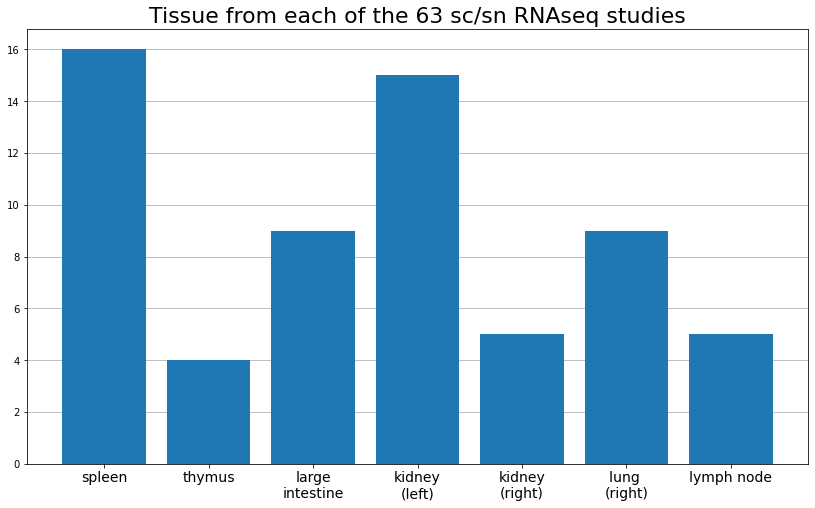

In [54]:


plt.figure(figsize=(14,8))
plt.bar(height=organ_counts.values[0],x=organ_counts.columns)

plt.grid(axis= 'y'); plt.gca().set_axisbelow(True)
plt.title('Tissue from each of the 63 sc/sn RNAseq studies',fontsize=22)

plt.xticks(fontsize=14);plt.show()

In [22]:
stats['orginal_count_matrix_shape'].nunique()

63

In [21]:
stats['STUDY_UUID'].nunique()

63

In [23]:
stats['STUDY_NAME'].nunique()

24

In [14]:
Counter(stats['STUDY_NAME']).most_common()

[('snRNA-seq [Salmon] data from the kidney (left) of a donor of unknown age, race and sex',
  10),
 ('snRNA-seq [Salmon] data from the lung (right) of a 37.0-year-old black or african american male',
  9),
 ('scRNA-seq (10x Genomics) [Salmon] data from the spleen of a 18-year-old white male',
  5),
 ('snRNA-seq [Salmon] data from the large intestine of a 24-year-old white female',
  4),
 ('scRNA-seq (10x Genomics) [Salmon] data from the spleen of a 18-year-old black or african american male',
  3),
 ('snRNA-seq [Salmon] data from the kidney (left) of a 66-year-old white male',
  3),
 ('snRNA-seq [Salmon] data from the large intestine of a 78-year-old black or african american male',
  3),
 ('snRNA-seq [Salmon] data from the kidney (right) of a donor of unknown age, race and sex',
  3),
 ('scRNA-seq (10x Genomics) [Salmon] data from the spleen of a 20-year-old white male',
  2),
 ('scRNA-seq (10x Genomics) [Salmon] data from the thymus of a 18-year-old black or african american male',
 

In [11]:
[print(s) for s in  stats['STUDY_NAME']]


scRNA-seq (10x Genomics) [Salmon] data from the spleen of a 20-year-old white male
scRNA-seq (10x Genomics) [Salmon] data from the spleen of a 18-year-old black or african american male
scRNA-seq (10x Genomics) [Salmon] data from the thymus of a 18-year-old black or african american male
snRNA-seq [Salmon] data from the kidney (left) of a 66-year-old white male
snRNA-seq [Salmon] data from the large intestine of a 78-year-old black or african american male
snRNA-seq [Salmon] data from the kidney (left) of a 66-year-old white male
snRNA-seq [Salmon] data from the large intestine of a 24-year-old white female
snRNA-seq [Salmon] data from the large intestine of a 67-year-old white female
scRNA-seq (10x Genomics) [Salmon] data from the lymph node of a 1-year-old white male
snRNA-seq [Salmon] data from the kidney (left) of a donor of unknown age, race and sex
snRNA-seq [Salmon] data from the kidney (left) of a 25-year-old white female
snRNA-seq [Salmon] data from the kidney (left) of a dono

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [84]:
Counter([s.split(' ')[0] for s in stats['STUDY_NAME']])

Counter({'scRNA-seq': 25, 'snRNA-seq': 38})

In [76]:
# All studies contain the word 'Salmon', 
assert np.all(['Salmon' in s for s in stats['STUDY_NAME']])

In [3]:
len(np.unique(stats['STUDY_NAME']))


24

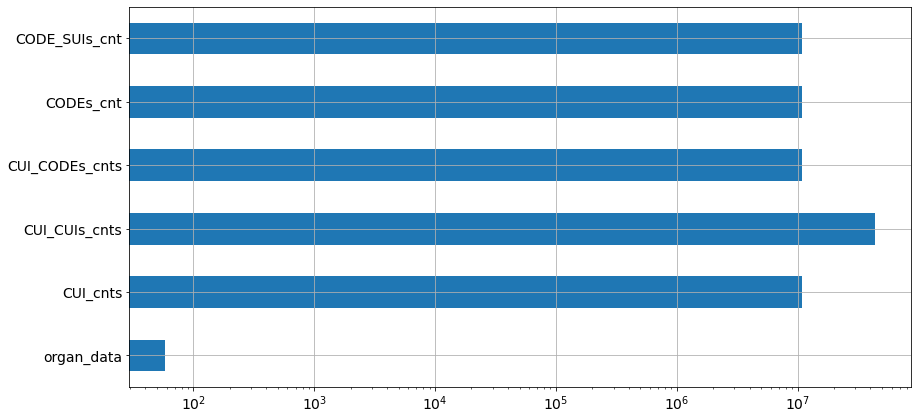

In [4]:
plt.figure(figsize=(14,7))
stats.iloc[:,7:].sum().plot(kind='barh')
plt.xscale('log')
plt.grid('y')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14); plt.show()

In [102]:
total_num_cells = study_num_samples.sum()
total_num_cells

0    446152
dtype: int64

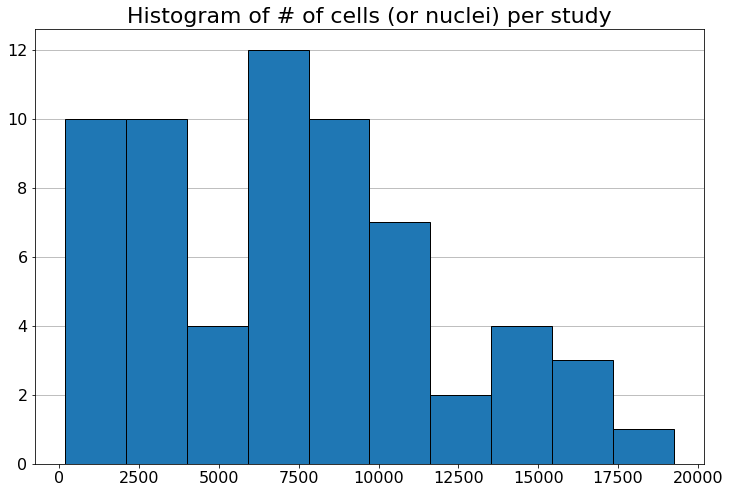

In [15]:
study_num_samples = pd.DataFrame([int(i.split(',')[0][1:])  for i in stats['orginal_count_matrix_shape']])

plt.figure(figsize=(12,8))
plt.hist(study_num_samples,ec='k'); #plt.show()
plt.grid(axis= 'y'); plt.gca().set_axisbelow(True)
plt.title('Histogram of # of cells (or nuclei) per study',fontsize=22)

plt.gca().tick_params(axis='x', labelsize= 16)
plt.gca().tick_params(axis='y', labelsize= 16)

In [92]:
# Number of genes per study
study_num_genes = [int(i.split(',')[1][:-1])  for i in stats['orginal_count_matrix_shape']]
Counter(study_num_genes)

Counter({60286: 50, 38032: 13})

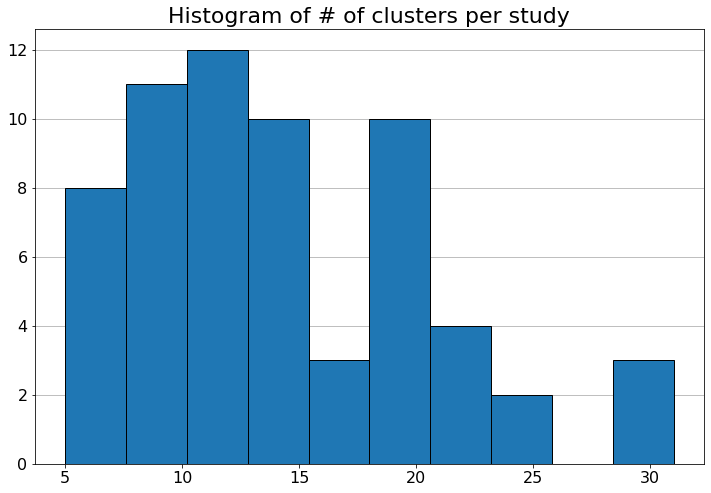

In [16]:
plt.figure(figsize=(12,8))
plt.hist(stats['num_clusters'],ec='k'); #plt.show()
plt.grid(axis= 'y'); plt.gca().set_axisbelow(True)
plt.title('Histogram of # of clusters per study',fontsize=22)

plt.gca().tick_params(axis='x', labelsize= 16)
plt.gca().tick_params(axis='y', labelsize= 16)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

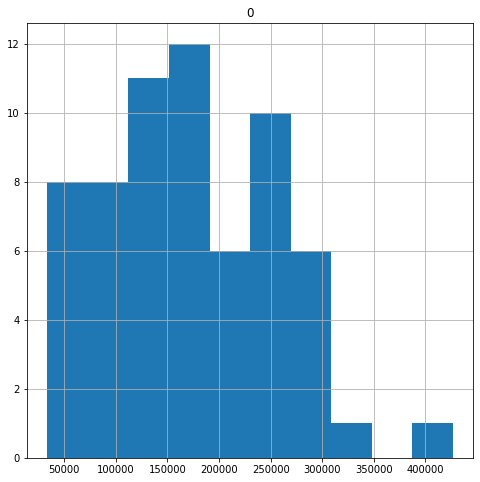

In [82]:
study_concat_clshape = pd.DataFrame([int(i.split(',')[0][1:])  for i in stats['concat_cluster_shape']])

study_concat_clshape.hist(figsize=(8,8))

In [194]:
metadata_cat_dict_split = [i.split('_CUI')[0] for i in list(metadata_cat_dict.keys())]
metadata_cat_dict_split

['Race',
 'Sex',
 'Medical history',
 'Cause of death',
 'Mechanism of injury',
 'Death event',
 'Social history',
 'Blood type',
 'Body mass index']

In [19]:
stats['orginal_count_matrix_shape'].nunique()

63

In [ ]:
stats

In [176]:
# FOR TESTING ONLY, NOT PART OF INGESTION

def find_all_metadata_dataset_mappings(study_id):
    
    metadata = get_metadata(study_id)
    
    DONOR_CODE = None
    for ancestor in metadata['ancestors']:
        if ancestor['entity_type'] == 'Donor':
            DONOR_CODE = ancestor['uuid']
    assert DONOR_CODE != None
    
    DATASET_CODE = None
    for descendant in metadata['descendants']:
        if descendant['entity_type'] == 'Dataset': DATASET_CODE = descendant['uuid']
    if DATASET_CODE == None:
        for ancestor in metadata['ancestors']:
            if ancestor['entity_type'] == 'Dataset': DATASET_CODE = ancestor['uuid']         
    assert DATASET_CODE != None

    metadata_cat_list = ['Race','Sex' ,'Medical history','Cause of death','Mechanism of injury',
                      'Death event','Social history','Blood type','Body mass index']

    meta_data_categories = []

    if 'organ_donor_data' in metadata['donor']['metadata'].keys():
        donor_key = 'organ_donor_data'
    elif 'living_donor_data' in metadata['donor']['metadata'].keys():
        donor_key = 'living_donor_data'
    for n,i in enumerate(metadata['donor']['metadata'][donor_key]):
                meta_data_categories.append(i['grouping_concept_preferred_term']) 
            
    #print(len(meta_data_categories))
    #print(meta_data_categories)
    meta_data_categories = [cat for cat in meta_data_categories if cat in metadata_cat_list]
    print(study_id)
    #print(len(meta_data_categories))
    #print(meta_data_categories)
    #assert len(set(meta_data_categories)) == len(meta_data_categories), 'Duplicate Detected'
    #print('*'*50)

    return study_id,DATASET_CODE,DONOR_CODE,len(meta_data_categories),meta_data_categories
 

In [177]:
find_all_metadata_dataset_mappings('0d1eb3d774a694b79e844987f771b183')

0d1eb3d774a694b79e844987f771b183


('0d1eb3d774a694b79e844987f771b183',
 'fd0c0fcde5a331c9dfff52b520c7d792',
 '48b15ba8abfaef4e70edfdf173649b6c',
 5,
 ['Race', 'Sex', 'Body mass index', 'Medical history', 'Medical history'])

In [162]:
connection_data = []
for study_id in study_ids:
    print(study_id)
    connection_data.append(find_all_metadata_dataset_mappings(study_id))

046251c94ea0e79ee935dd3de57e093c
046251c94ea0e79ee935dd3de57e093c
3f678ab5cd7ed086ec0d2d4468fc5094
3f678ab5cd7ed086ec0d2d4468fc5094
81a9fa68b2b4ea3e5f7cb17554149473
81a9fa68b2b4ea3e5f7cb17554149473
be103f95cc6c1a3e48f099d1bd149a49
be103f95cc6c1a3e48f099d1bd149a49
04968c1fe0149ee367b0e53af55763e4
04968c1fe0149ee367b0e53af55763e4


AssertionError: Duplicate Detected

In [159]:
connection_data = pd.DataFrame(connection_data)
connection_data.columns = ['study_id','dataset_id','donor_id','metadata_num','metadata_categories']
connection_data.to_csv('connnection_data.csv',index=False)

In [141]:
connection_data['metadata_categories'][0][0]


'Sex'

In [73]:
#Counter(HUBMAP_TISSUE_CUI_CUI[HUBMAP_TISSUE_CUI_CUI[':END_ID'].str.startswith('C')][':END_ID'])

# switch to using salmon output, and spliced/unspliced or sum of both?

In [ ]:
# there can be many rui-locations if there are more than one sample.

In [232]:
j=get_metadata('68159e4bd6a2cea1cd66e8f3050cfcb7')

In [233]:

#print(json.dumps(j['descendants'], indent=2))

for i in j['ancestors']:
    #print(i['entity_type'])
    if i['entity_type'] == 'Dataset':
        a=i
        print(json.dumps(i, indent=2)) 
    print('*'*100)

{
  "contains_human_genetic_sequences": true,
  "created_by_user_displayname": "Jesus Penaloza Aponte",
  "created_by_user_email": "jesus.penalozaa@ufl.edu",
  "created_timestamp": 1576356134299,
  "data_access_level": "protected",
  "data_types": [
    "scRNA-Seq-10x"
  ],
  "dataset_info": "HBMP1_thymus_2\r\n\r\nRaw fastq files for Case 1 Thymus 2\nMetadata Missing",
  "description": "Raw fastq files for Case 1 Thymus 2\nMetadata Missing",
  "entity_type": "Dataset",
  "group_uuid": "07a29e4c-ed43-11e8-b56a-0e8017bdda58",
  "hubmap_id": "HBM895.WHGJ.263",
  "lab_dataset_id": "HBMP1_thymus_2",
  "last_modified_timestamp": 1598109439116,
  "mapped_data_access_level": "Protected",
  "mapped_data_types": [
    "scRNA-seq (10x Genomics v3)"
  ],
  "mapped_last_modified_timestamp": "2020-08-22 15:17:19",
  "mapped_metadata": {},
  "mapped_status": "Published",
  "metadata": {
    "dag_provenance_list": [
      {
        "hash": "8c8296d",
        "origin": "https://github.com/hubmapconsort

In [65]:

request = urllib.request.urlopen('https://portal.hubmapconsortium.org/browse/dataset/35f5b75a7e3d0711f16b0a10219586fb.json')
j = json.load(request)

In [66]:
[i['entity_type'] for i in j['ancestors']]

['Dataset', 'Sample', 'Sample', 'Sample', 'Donor']

In [ ]:
organ_metadata = json.loads(x)['ccf_annotations']
organ_CodeIDs = [i.split('/')[-1] for i in organ_metadata]

In [45]:
print(json.dumps(j, indent=2))

{
  "anatomy_0": [
    "body"
  ],
  "anatomy_1": [
    "spleen"
  ],
  "ancestor_counts": {
    "entity_type": {
      "Dataset": 1,
      "Donor": 1,
      "Sample": 3
    }
  },
  "ancestor_ids": [
    "01844e5a048e03aa434ee0afb71c813d",
    "3d2bc79885fc7720f77fddd2c23f02e5",
    "c3ae72c46047373fa579b4d2e37bdb3b",
    "c67c421ac4aed2c8bede2a1d0acb4eec",
    "d386672d8d067ee117a086710cfbde5a"
  ],
  "ancestors": [
    {
      "contains_human_genetic_sequences": true,
      "created_by_user_displayname": "Jason Brant",
      "created_by_user_email": "jobrant@ufl.edu",
      "created_timestamp": 1606682659317,
      "data_access_level": "protected",
      "data_types": [
        "scRNA-Seq-10x"
      ],
      "dataset_info": "10X_UFL0006-SP-1-1-2",
      "entity_type": "Dataset",
      "group_uuid": "07a29e4c-ed43-11e8-b56a-0e8017bdda58",
      "hubmap_id": "HBM263.TLLN.467",
      "lab_dataset_id": "10X_UFL0006-SP-1-1-2",
      "last_modified_timestamp": 1619990452494,
      "mapped

In [ ]:
# how to check if its a spatial dataset

'data_types': ['Slide-seq'],
   'dataset_info': 'Slide-seq data from the kidney (right) of a donor of unknown age, race and sex\r\n\r\n19 Slide-seq arrays of the right kidney cortex from donor UCSD0020  : upload/Puck_200506_05',
   'description': '19 Slide-seq arrays of the right kidney cortex from donor UCSD0020  : upload/Puck_200506_05',
    
"mapped_data_types": [
    "Slide-seq"
  ],
        
"metadata": {"assay_type": "Slide-seq","description": "Slide-seq on the kidney cortex",
             "puck_id": "Puck_200506_05",
          "rnaseq_assay_method": "Slide-Seq",
             
# file info             
"rel_path": "spatial_pos_by_leiden_cluster.pdf",
             
# if a file has the word 'spatial' in it

In [26]:
#  Check that the donor uuid's are unique in each study, 
# we only have 23 unique ones in the final CSV and the graph.
donor_uuids = []

for f in study_ids:
    metadata = get_metadata(f)
    for ancestor in metadata['ancestors']:
        if ancestor['entity_type'] == 'Donor':
            #print(ancestor['uuid'])
            DONOR_CODE = ancestor['uuid']
    donor_uuids.append(DONOR_CODE)

    
# This ^ is okay, many of the donors were used in more than one study 

In [28]:
len(np.unique(donor_uuids))


23